## Feedfoward DNN w/ Tensorflow

**Dataset**
- MNIST Classification


In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Load MNIST Data

In [2]:
# Get Data From Tensorflow Tutorial and save copy to local directory
from tensorflow.examples.tutorials.mnist import input_data

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz
Original Training Shape: (55000, 784)
Original Testing Shape: (55000, 784)
Reformat to 28x28 Pixels Shape: (55000, 28, 28)


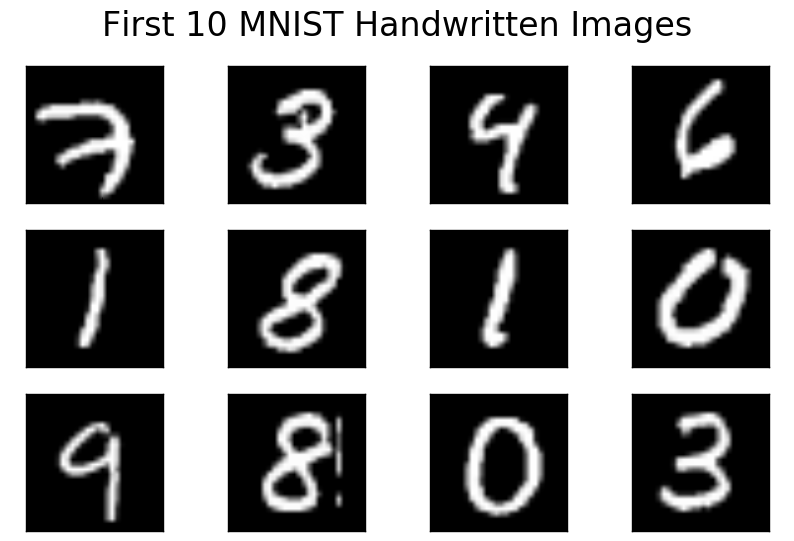

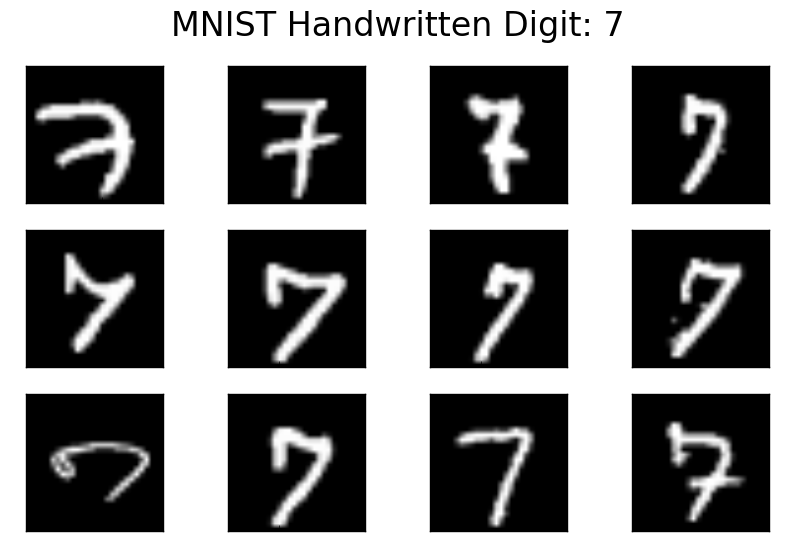

In [3]:
def process_data(mnist):
    
    """
    Return preprocessed Training/Testing subsets of the MNIST Images
    
    Keyword arguments:
    None
    """
    
    X_train = mnist.train.images
    X_test = mnist.test.images
    print('Original Training Shape:',X_train.shape)
    print('Original Testing Shape:',X_train.shape)
    
    #Training/Testing Labels
    y_train,y_test = mnist.train.labels,mnist.test.labels
    
    #Reshape Data into 28x28 pixels
    X_train_reshape = X_train.reshape(X_train.shape[0],28,28)
    X_test_reshape = X_test.reshape(X_test.shape[0],28,28)
    
    print('Reformat to 28x28 Pixels Shape:',X_train_reshape.shape)
    return(X_train,X_test,y_train,y_test,X_train_reshape,X_test_reshape)

def explore_images(X,images=10):
    n_col = 4
    n_row = int(np.ceil(images/n_col))
    
    fig = plt.figure(figsize=(2.5*n_col,2.0*n_row))
    plt.title('First %.0f MNIST Handwritten Images' % images, fontsize=24,y=1.05)
    plt.box(False)
    plt.xticks(())
    plt.yticks(())
    for img,i in enumerate(range(n_row*n_col)):
        ax = fig.add_subplot(n_row,n_col,i+1)
        ax.imshow(X[img],cmap='gray',interpolation=None)
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        
def explore_specific_digits(X,y,digit,images=10):
                            
    X = X[np.argmax(y,axis=1) == digit]
    
    n_col = 4
    n_row = int(np.ceil(images/n_col))
    
    fig = plt.figure(figsize=(2.5*n_col,2.0*n_row))
    plt.title('MNIST Handwritten Digit: %s' % digit, fontsize=24,y=1.05)
    plt.box(False)
    plt.xticks(())
    plt.yticks(())
    for img,i in enumerate(range(n_row*n_col)):
        ax = fig.add_subplot(n_row,n_col,i+1)
        ax.imshow(X[img],cmap='gray',interpolation=None)
        ax.set_xticklabels('')
        ax.set_yticklabels('')

        
if __name__ == '__main__':
    
    #Load MNIST and store locally
    mnist = input_data.read_data_sets('data/MNIST_data',one_hot=True)
    
    #Prep Data
    X_train,X_test,y_train,y_test,X_train_reshape,X_test_reshape = process_data(mnist)
    
    #Explore Images
    explore_images(X_train_reshape)
    
    #Explore Specific Digits
    explore_specific_digits(X_train_reshape,y_train,7)

(4000, 7000.0)

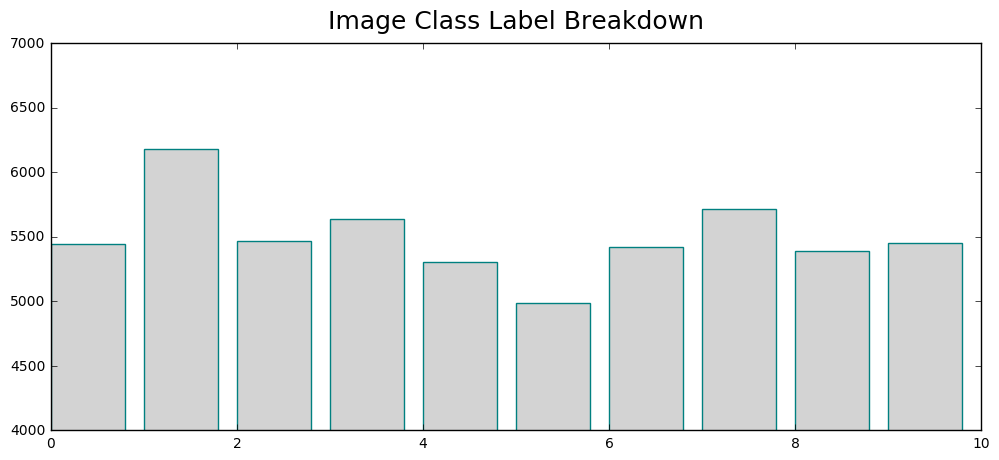

In [4]:
plt.figure(figsize=(12,5))
plt.title('Image Class Label Breakdown',fontsize=18,y=1.02)
plt.bar(np.arange(0,10,1),np.bincount(np.argmax(y_train,axis=1)),color='lightgray',edgecolor='teal')
plt.ylim(4000)

## Build Neural Network

- In this notebook, we will construct s deep feed-forward neural network -- MLP Classifier


- Classify MNIST Handwritten Images: [0-9]


- **Architecture:**

    - Input Dimensions: 784 
    - Hidden Layers: 3
    - Units in Each Layer: 256
    - Output: 10

In [94]:
class Feedforward_Neural_Net():
    
    def __init__(self,architecture):
    
        #Neural Network Structure
        self.architecture = architecture

        #Input Features and Labels
        self.X = tf.placeholder(tf.float32,[None,self.architecture['n_inputs']])
        self.Y = tf.placeholder(tf.float32,[None,self.architecture['n_classes']])

        #Initialize Build and return predicted proba
        self.logits = self.build_model()

        #Initialize Optimization
        self.optimization()

        #Initalize Global Variables
        init_g = tf.global_variables_initializer()
        
        #Create Tensorflow Session
        self.sess = tf.Session() 
        self.sess.run(init_g)

        
    def initialize_weights(self):
        
        """
        Returns weights and biases
        
        """
        
        s = self.architecture
        initializer = tf.random_normal
        
        weights = {
    
            'weights1': tf.Variable(initializer([s['n_inputs'], s['hidden1']])),
            'weights2': tf.Variable(initializer([s['hidden1'], s['hidden2']])),
            'weights3': tf.Variable(initializer([s['hidden2'], s['hidden3']])),
            'out': tf.Variable(initializer([s['hidden3'], s['n_classes']])),
            }
    
        biases = {
            
            'bias1': tf.Variable(initializer([s['hidden1']])),
            'bias2': tf.Variable(initializer([s['hidden2']])),
            'bias3': tf.Variable(initializer([s['hidden3']])),
            'out': tf.Variable(initializer([s['n_classes']])),
            }
        
        return(weights,biases)
    
    
    def build_model(self):
    
        """ Build Neural Network and Update Weights -- Return Reconstructed Output"""
        
        weights,bias = self.initialize_weights()

        #Activation Output1 -- tf.matmul multiplies matrix X by matrix w (x.w) -- then summation
        hidden1 = tf.nn.sigmoid(tf.add(tf.matmul(self.X,weights['weights1']),bias['bias1']))
        
        #Activation Output2 -- tf.matmul multiplies matrix X by matrix w (x.w) -- then summation
        hidden2 = tf.nn.sigmoid(tf.add(tf.matmul(hidden1,weights['weights2']),bias['bias2']))

        #Activation Output3 -- tf.matmul multiplies matrix X by matrix w (x.w) -- then summation
        hidden3 = tf.nn.sigmoid(tf.add(tf.matmul(hidden2,weights['weights3']),bias['bias3']))

        #Predicted Probability 
        logits = tf.add(tf.matmul(hidden3,weights['out']),bias['out'],name='output')

        return(logits)
    
    def optimization(self):
        
        """ Minimize Cost Function -- Cross-Entropy"""

        #Compute Cross-Entropy
        self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.Y,logits=self.logits))

        #Optimizer -- Adaptive Moment Estimation (ADAM)
        self.optimizer = tf.train.AdamOptimizer().minimize(self.cross_entropy)
        
        
    def partial_fit(self,x,y):
        
        """ Return Cost for Each Mini-Batch """

        #Pass mini-batch through autoencoder and update weights/cost
        _, cost = self.sess.run([self.optimizer,self.cross_entropy],feed_dict={self.X:x,self.Y:y})
        return(cost)
                            
    
    def accuracy(self,x,y):
        
        """ Return Accuracy """
        
        predict = tf.nn.softmax(self.logits)
        y_pred = self.sess.run(predict,feed_dict={self.X:x,self.Y:y})
        acc = np.mean((np.argmax(y,axis=1)== np.argmax(y_pred,axis=1)))
        return(acc)

In [97]:
def neural_net_architecture():
    
    dicts = {

            'hidden1':256,
            'hidden2':256,
            'hidden3':256,
            'n_inputs':784,
            'n_classes':10,
            }
    
    return(dicts)

def train_neural_net(X_trani,y_train,X_test,y_test,batch_size,epochs,display_steps):
    
    #Get Neural Net Architecture
    architecture = neural_net_architecture()

    #Initialize Neural Net
    neural_net = Feedforward_Neural_Net(architecture)
    
    

    print('\n===================== Training w/ Mini-Batch =====================')
    print('Number of Epochs: ', epochs)
    print('Batch Size: ', batch_size)
    print('Display Steps: ', display_steps)
    print('===================================================================')
    
    loss,acc = [],[]
    for epoch in range(epochs):
        
        #Get Random Mini-Batch
        rand_idx = np.random.choice(len(X_train),size=batch_size)
        batch_x,batch_y = X_train[rand_idx],y_train[rand_idx]

        #Partial Fit for Mini-Batch
        cost = neural_net.partial_fit(batch_x,batch_y)

        #Get Accuracy
        accuracy = neural_net.accuracy(batch_x,batch_y)    
        acc.append(accuracy)
        
        #Compute Average Loss
        loss.append(cost / len(batch_x))
        
        #Print Summary Results
        if epoch % display_steps == 0:
            print('Epoch {0} -- Training Accuracy: {1:.4f}'.format(epoch,accuracy))
            

    print('===================================================================')
    print('Testing Accuracy: {0:.4f}'.format(neural_net.accuracy(X_test,y_test)))
            
    return(loss,acc)

def results_visual(results):
    
    """ Return Loss and Accuracy Visualization """
 
    #set up figure
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax1 = ax.twinx()
    
    for k,v in results.items():

        #Plot Loss and Accuracy
        ax.plot(v[0],lw=2)
        ax1.plot(v[1],lw=2,label='%s' % k)

        #Axis labels
        ax.set_ylabel('Loss')
        ax1.set_ylabel('Accuracy')
        ax.set_xlabel('Epochs')

        #Set Legends
        ax1.legend(loc=(1.08,.50),frameon=False)

        plt.title('MLP Results: Accuracy and Loss',fontsize=18,y=1.02)


In [98]:
if __name__ == '__main__':
    
        train_neural_net(X_train,y_train,X_test,y_test,250,1000,50)


===================== Training w/ Mini-Batch =====================
Number of Epochs:  1000
Batch Size:  250
Display Steps:  50
Epoch 0 -- Training Accuracy: 0.1040
Epoch 50 -- Training Accuracy: 0.3560
Epoch 100 -- Training Accuracy: 0.5760
Epoch 150 -- Training Accuracy: 0.6400
Epoch 200 -- Training Accuracy: 0.6960
Epoch 250 -- Training Accuracy: 0.7840
Epoch 300 -- Training Accuracy: 0.8000
Epoch 350 -- Training Accuracy: 0.7840
Epoch 400 -- Training Accuracy: 0.8040
Epoch 450 -- Training Accuracy: 0.8040
Epoch 500 -- Training Accuracy: 0.7680
Epoch 550 -- Training Accuracy: 0.8640
Epoch 600 -- Training Accuracy: 0.8440
Epoch 650 -- Training Accuracy: 0.8360
Epoch 700 -- Training Accuracy: 0.8680
Epoch 750 -- Training Accuracy: 0.8800
Epoch 800 -- Training Accuracy: 0.8840
Epoch 850 -- Training Accuracy: 0.8600
Epoch 900 -- Training Accuracy: 0.8920
Epoch 950 -- Training Accuracy: 0.8960
Testing Accuracy: 0.8610


### Tune for Batch Size


===================== Training w/ Mini-Batch =====================
Number of Epochs:  1000
Batch Size:  50
Epoch 0 -- Training Accuracy: 0.1600
Epoch 100 -- Training Accuracy: 0.4800
Epoch 200 -- Training Accuracy: 0.5800
Epoch 300 -- Training Accuracy: 0.7800
Epoch 400 -- Training Accuracy: 0.7200
Epoch 500 -- Training Accuracy: 0.7800
Epoch 600 -- Training Accuracy: 0.8000
Epoch 700 -- Training Accuracy: 0.8400
Epoch 800 -- Training Accuracy: 0.7800
Epoch 900 -- Training Accuracy: 0.8600
Testing Accuracy: 0.8111

===================== Training w/ Mini-Batch =====================
Number of Epochs:  1000
Batch Size:  100
Epoch 0 -- Training Accuracy: 0.1600
Epoch 100 -- Training Accuracy: 0.5000
Epoch 200 -- Training Accuracy: 0.6100
Epoch 300 -- Training Accuracy: 0.7200
Epoch 400 -- Training Accuracy: 0.7900
Epoch 500 -- Training Accuracy: 0.8000
Epoch 600 -- Training Accuracy: 0.7600
Epoch 700 -- Training Accuracy: 0.8200
Epoch 800 -- Training Accuracy: 0.8600
Epoch 900 -- Training

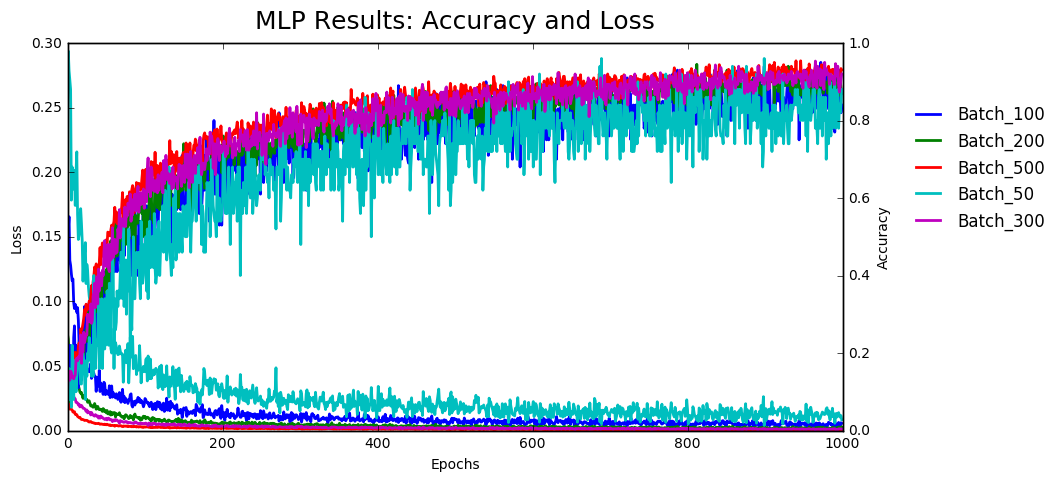

In [128]:
if __name__ == '__main__':
        
    batch_results = dict()
    
    #Batch sizes to train neural net
    batch_size = [50,100,200,300,500]
    
    for batches in batch_size:
        #Iterate over various batch sizes
        batch_results['Batch_{}'.format(batches)] = train_neural_net(X_train,y_train,X_test,y_test,batches,1000,100)
    
    #Get Visualization
    results_visual(batch_results)